## Imports, Settings, Data

In [1]:
import sys
sys.path.insert(0, "/home/jupyter/ML_for_slideseq")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

import torchvision
import pytorch_lightning as pl
import lightly
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize

from tissue_purifier.util_data import *

/opt/conda/lib/python3.7/site-packages/lightly/api/version_checking.py:57: Warning: You are using lightly version 1.1.12. There is a newer version of the package available. For compatability reasons, please upgrade your current version: pip install lightly==1.1.13
  warnings.warn(Warning(warning))


In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# plt.style.use("seaborn")
mpl.rcParams["figure.dpi"] = 200

In [4]:
root = "/home/jupyter/data/slide-seq/original_data/"

df_wt1 = pd.read_csv(root + "wt_1.csv")
df_wt2 = pd.read_csv(root + "wt_2.csv")
df_wt3 = pd.read_csv(root + "wt_3.csv")
df_dis1 = pd.read_csv(root + "sick_1.csv")
df_dis2 = pd.read_csv(root + "sick_2.csv")
df_dis3 = pd.read_csv(root + "sick_3.csv")

all_df = [df_wt1, df_wt2,df_wt3, df_dis1, df_dis2, df_dis3]

In [5]:
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 100
input_size = 224
num_ftrs = 128
pixel_size = 5
crop_size = 224
input_channels = 9
n_element_min = 200

In [6]:
all_df = [df_wt1, df_wt2, df_wt3, df_dis1, df_dis2, df_dis3]
# all_df = [df_wt2, df_dis2]
# all_df = [df_wt2, df_dis2]
sparse_images = [
    SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]
# labels_sparse_images = [0, 0, 0, 1, 1, 1]
labels_sparse_images = [0, 1, 2, 3, 4, 5]

n_crops_test = 500

testdata_transform = torchvision.transforms.Compose([
    StackTensor(dim=-4),
    RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

testdataset = SparseDataset(
    x=RandomCropSparseTensor(
        n_crops=n_crops_test,
        crop_size=crop_size,
        n_element_min=n_element_min,
        test_cache_key="test"
    )(sparse_images), 
    y=Interleave(n_repeat=n_crops_test)(labels_sparse_images)
)

dataloader_test = DataLoaderWithLoad(
    testdataset,
    batch_size=batch_size,
    collate_fn=SpecialCollateFn(transform=testdata_transform, simclr_output=False),
    shuffle=False
)

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 928, 928])


In [7]:
all_df = [df_wt1,df_wt3, df_dis1, df_dis3]

sparse_images = [
    SparseImage.from_panda(
        df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
    ) 
    for df in all_df
]
labels_sparse_images = [0, 0, 1, 1]
n_crops_train = 400

sparse_dataset_train = SparseDataset(
    x=RandomCropSparseTensor(
        n_crops=n_crops_train,
        crop_size=crop_size,
        n_element_min=n_element_min,
    )(sparse_images), 
    y=Interleave(n_repeat=n_crops_train)(labels_sparse_images)
)

train_transform = torchvision.transforms.Compose([
    StackTensor(dim=-4),
    RandomGaussianBlur(sigma=(1.0, 1.0)),
    torchvision.transforms.Resize(input_size)
])

dataloader_train = DataLoaderWithLoad(
    sparse_dataset_train,
    batch_size=sparse_dataset_train.__len__(),
    collate_fn=SpecialCollateFn(transform=train_transform, simclr_output=False),
    shuffle=True
)

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 39206
The dense shape of the image is -> torch.Size([9, 940, 940])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])
number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 928, 928])


## Embeddings from trained SimCLR model

In [7]:
from torch import nn
import torchvision

resnet = torchvision.models.resnet18()
last_conv_channels = list(resnet.children())[-1].in_features
first_conv_out_channels = list(resnet.children())[0].out_channels
backbone = torch.nn.Sequential(
    torch.nn.Conv2d(input_channels, first_conv_out_channels, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
    *list(resnet.children())[1:-1],
    torch.nn.Conv2d(last_conv_channels, num_ftrs, 1),
)

ckpt = torch.load("model.pth")
backbone.load_state_dict(ckpt["resnet18_parameters"])
# create the SimCLR model using the loaded created backbone
model = lightly.models.SimCLR(backbone, num_ftrs=num_ftrs)

In [8]:
import torch
import lightly
from src import models

criterion = lightly.loss.NTXentLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=[0.9, 0.999])

encoder = lightly.embedding.SelfSupervisedEmbedding(
    model,
    criterion,
    optimizer,
    dataloader_test
)

In [9]:
device = "cuda"
encoder = encoder.to(device)

embeddings, labels, fnames = encoder.embed(dataloader_test, device=device, to_numpy=True)

Compute efficiency: 0.01: 100%|██████████| 12/12 [00:04<00:00,  2.52it/s]


In [10]:
embeddings.shape

(3000, 128)

In [120]:
classes = [0 if label in [0, 1, 2] else 1 for label in labels]

## KMeans Clustering

In [121]:
from sklearn.utils import shuffle

# X, y_l, y_c = shuffle(embeddings,labels, classes)
X, y_l, y_c = embeddings, labels, classes

In [139]:
from sklearn.cluster import KMeans

X_tr = KMeans(n_clusters=2, random_state=0).fit_predict(X[(y_l == 0) | (y_l == 3)])

In [123]:
from sklearn.metrics import accuracy_score

accuracy_score(X_tr, y_c)

0.48733333333333334

In [107]:
X_tr[y_l == 4]

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1,

In [124]:
from simple_cache import cache

offset = 0
CROP_SIZE = 224

def get_sickness_mask(image, image_label):
    intensity_mask = np.zeros(image.shape[:-1])
    count_mask = np.zeros(image.shape[:-1])
    xys = cache["test"]
    for i, (proba, real_answer) in enumerate(zip(X_tr, y_l)):
        if real_answer == image_label:
            crop_i, crop_j = xys[fnames[i]]
            intensity_mask[
                crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset
            ] += proba
            count_mask[crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset] += 1
            
    
    return intensity_mask / (count_mask + 0.0000000001), count_mask

In [125]:
# img_wt2 = get_dense_image(df_wt2)
img_dis2 = get_dense_image(df_dis2)

number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


In [130]:
mask_1,_ = get_sickness_mask(img_dis2, image_label=4)
mask_1 = np.where(mask_1 > 0.55, 1, 0)

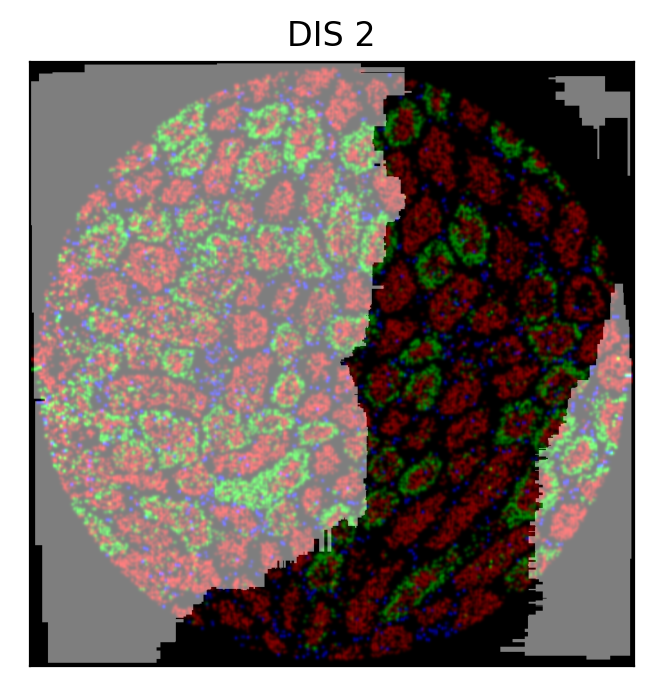

In [132]:
plt.imshow(img_dis2[:,:,:3])
plt.imshow(mask_1, alpha=0.5, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("DIS 2");

In [140]:
img_wt1 = get_dense_image(df_wt1)
mask_wt1, _ = get_sickness_mask(img_wt1, image_label=0)
mask_wt1 = np.where(mask_wt1 > 0.55, 1, 0)

img_dis1 = get_dense_image(df_dis1)
mask_dis1, _ = get_sickness_mask(img_dis1, image_label=3)
mask_dis1 = np.where(mask_dis1 > 0.55, 1, 0)

number of elements ---> 31659
The dense shape of the image is -> torch.Size([9, 938, 939])
number of elements ---> 27194
The dense shape of the image is -> torch.Size([9, 937, 940])


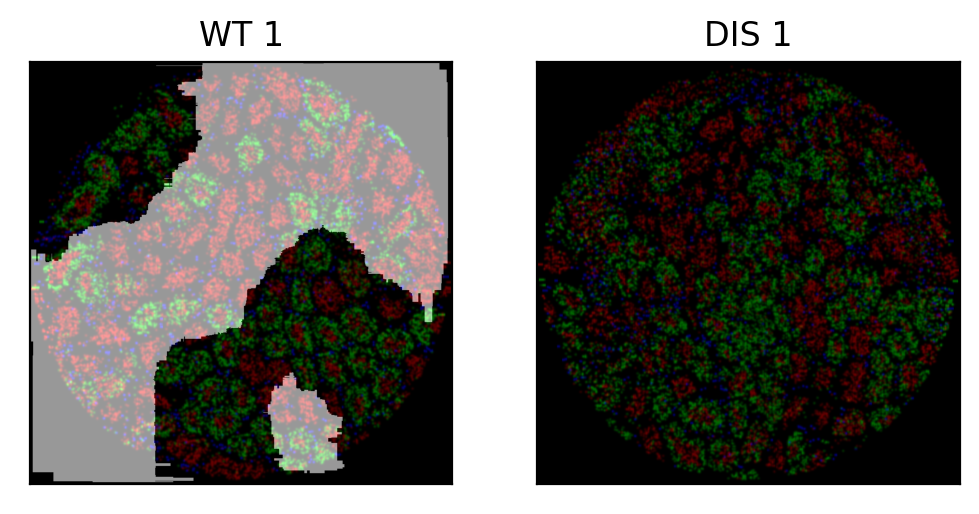

In [141]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3))

ax1.imshow(img_wt1[:,:,:3])
ax1.imshow(mask_wt1, alpha=0.6, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("WT 1")

ax2.imshow(img_dis1[:,:,:3])
ax2.imshow(mask_dis1, alpha=0.6, cmap="gray")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("DIS 1");

## PCA Based Mask

In [85]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

emb_scaled = StandardScaler().fit_transform(embeddings)
pca_embedded = PCA(n_components=1).fit_transform(emb_scaled)

In [86]:
pca_embedded = pca_embedded.reshape((3000,))

In [87]:
from sklearn.preprocessing import minmax_scale

pca_embedded = 1 - minmax_scale(pca_embedded)

In [88]:
from sklearn.preprocessing import minmax_scale 


def get_dense_image(df):
    t = RandomGaussianBlur(sigma=(1.0, 1.0))(
        SparseImage.from_panda(
            df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
        ).to_dense()
    )
    
    a = np.zeros(t.shape)
    for i in range(9):
        a[i] = minmax_scale(t[i].cpu())
        
    return a.transpose((1, 2, 0))

In [89]:
img_wt2 = get_dense_image(df_wt2)
img_dis2 = get_dense_image(df_dis2)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


In [139]:
from simple_cache import cache

offset = 0
CROP_SIZE = 224

def get_sickness_mask(image, image_label):
    intensity_mask = np.zeros(image.shape[:-1])
    count_mask = np.zeros(image.shape[:-1])
    xys = cache["test"]
    for i, (proba, real_answer) in enumerate(zip(pca_embedded, labels)):
        if real_answer == image_label:
            crop_i, crop_j = xys[fnames[i]]
            intensity_mask[
                crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset
            ] += proba
            count_mask[crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset] += 1
            
    
    return intensity_mask / (count_mask + 0.0000000001), count_mask

In [146]:
mask_1,_ = get_sickness_mask(img_dis2, image_label=4)
mask_1 = np.where(mask_1 > 0.68, 1, 0)

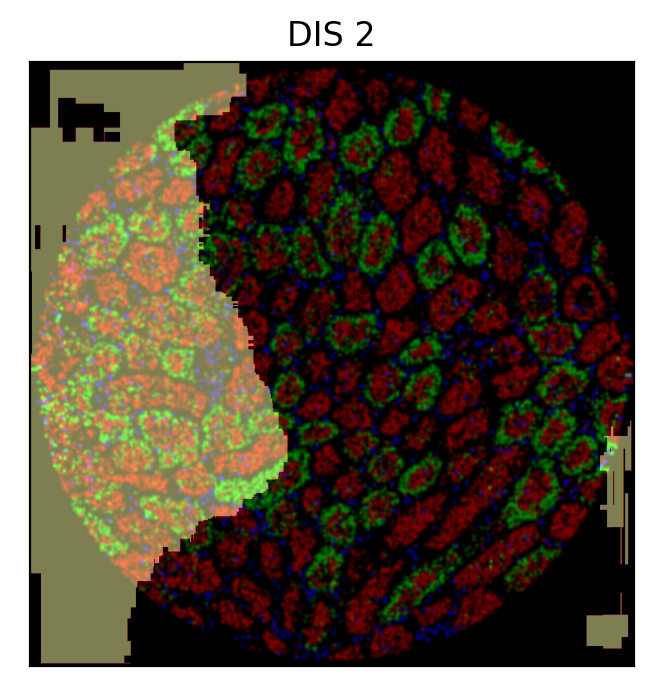

In [147]:
plt.imshow(img_dis2[:,:,:3])
plt.imshow(mask_1, alpha=0.5, cmap="inferno")
plt.xticks([])
plt.yticks([])
plt.title("DIS 2");

In [107]:
mask_2, _ = get_sickness_mask(img_wt2, image_label=2)
mask_2 = np.where(mask_2 > 0.7, 1, 0)

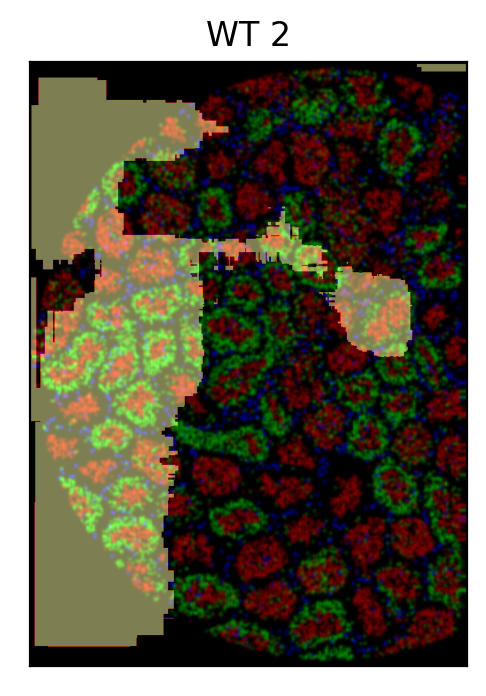

In [108]:
plt.imshow(img_wt2[:,:,:3])
plt.imshow(mask_2, alpha=0.5, cmap="inferno")
plt.xticks([])
plt.yticks([])
plt.title("WT 2");

number of elements ---> 33441
The dense shape of the image is -> torch.Size([9, 928, 928])


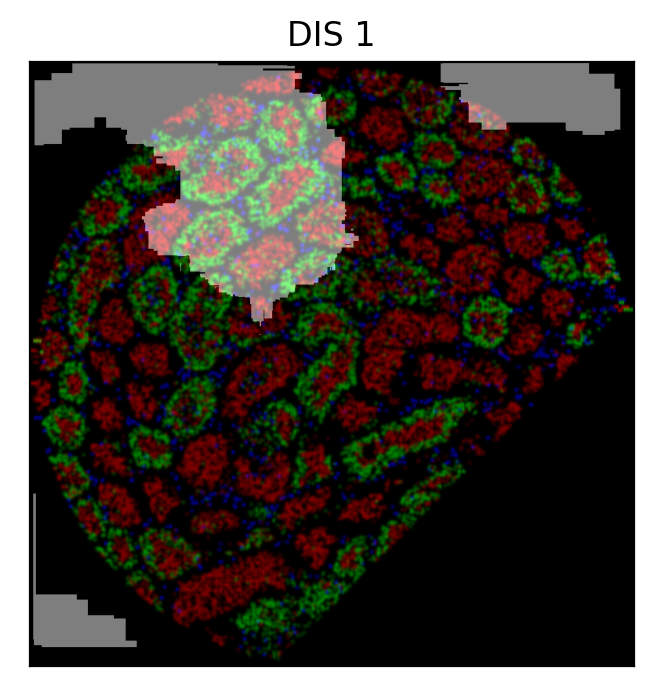

In [131]:
img_dis1 = get_dense_image(df_dis3)
mask_3, _ = get_sickness_mask(img_dis1, image_label=5)

mask_3 = np.where(mask_3 > 0.7, 1, 0)
plt.imshow(img_dis1[:,:,:3])
plt.imshow(mask_3, alpha=0.5, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("DIS 1");

## Linear Model

In [10]:
import pytorch_lightning as pl
import torch

class Classifier(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        # create a moco based on ResNet
        self.resnet_moco = model

        # freeze the layers of moco
        for p in self.resnet_moco.parameters():  # reset requires_grad
            p.requires_grad = False

        # we create a linear layer for our downstream classification
        # model
        self.fc = nn.Linear(128, 2)

        self.accuracy = pl.metrics.Accuracy()

    def forward(self, x):
        with torch.no_grad():
            y_hat = self.resnet_moco.backbone(x).squeeze()
            y_hat = nn.functional.normalize(y_hat, dim=1)
        
        y_hat = self.fc(y_hat)
        return y_hat


    def training_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        loss = nn.functional.cross_entropy(y_hat, y)
        self.log('train_loss_fc', loss)
        return loss


    def validation_step(self, batch, batch_idx):
        x, y, _ = batch
        y_hat = self.forward(x)
        self.accuracy(torch.softmax(y_hat, dim=-1), y)
        self.log('val_acc', self.accuracy.compute(), on_epoch=True, prog_bar=True)

    def configure_optimizers(self):
#         optim = torch.optim.SGD(self.fc.parameters(), lr=30.)
        optim = torch.optim.Adam(self.fc.parameters(), lr=0.001)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, max_epochs)
        return [optim], [scheduler]

In [11]:
from pytorch_lightning.loggers import NeptuneLogger


neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNjNhOTY3ZS1mOGU2LTQ2ZGItYTFmOS01MGY4ZDdiNGU1YTcifQ==",
    project_name='fedorgrab/slide-seq-contrastive',
    experiment_name="Linear Classifier of Embeddings",
    tags=["Embedding Classification"]
)

NeptuneLogger will work in online mode


In [12]:
model.eval()
classifier = Classifier(model=model)

In [20]:
gpus = 1

trainer = pl.Trainer(max_epochs=400, gpus=gpus, progress_bar_refresh_rate=25, logger=neptune_logger, log_every_n_steps=1)
trainer.fit(classifier, dataloader_train, dataloader_test)
print("DONE")

DONE


In [14]:
torch.save(classifier.state_dict(), "classifier.pt")
neptune_logger.experiment.log_artifact("classifier.pt")

## Inference

In [22]:
from sklearn.preprocessing import minmax_scale 


def get_dense_image(df):
    t = RandomGaussianBlur(sigma=(1.0, 1.0))(
        SparseImage.from_panda(
            df, x="x", y="y", category="cell_type", pixel_size=pixel_size, padding=10
        ).to_dense()
    )
    
    a = np.zeros(t.shape)
    for i in range(9):
        a[i] = minmax_scale(t[i].cpu())
        
    return a.transpose((1, 2, 0))

In [22]:
img_wt2 = get_dense_image(df_wt2)
img_dis2 = get_dense_image(df_dis2)

number of elements ---> 33059
The dense shape of the image is -> torch.Size([9, 940, 680])
number of elements ---> 42776
The dense shape of the image is -> torch.Size([9, 940, 940])


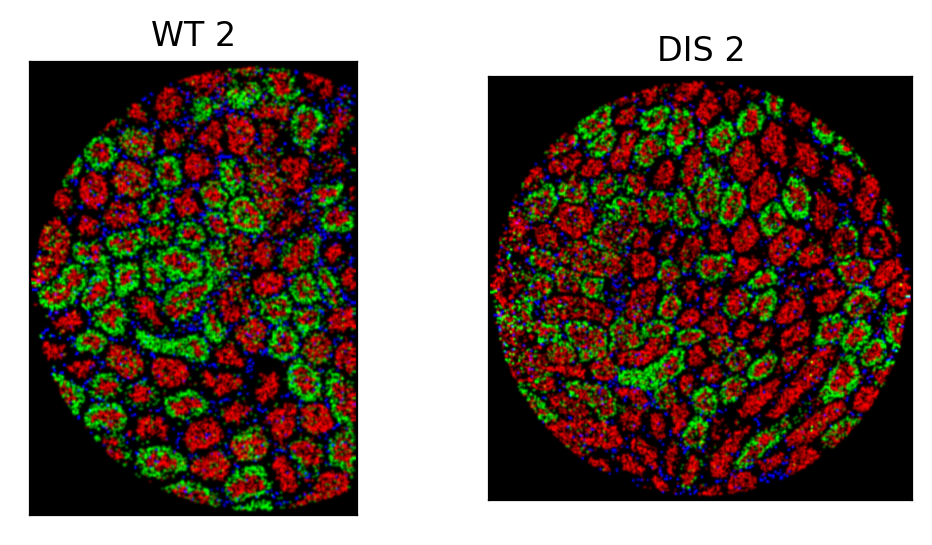

In [23]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax1.imshow(img_wt2[:,:,:3])
ax1.set_xticks([])
ax1.set_yticks([]);
ax1.set_title("WT 2")


ax2.imshow(img_dis2[:,:,:3])
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("DIS 2");

In [18]:
m = torch

In [41]:
y_true = []
y_probas = []
indicies = []

for batch, labels, fnames in dataloader_test:
#     print(batch.shape)
#     print(labels.shape)
#     break
    y_true.append(labels.cpu())
    y_probas.append(torch.softmax(classifier(batch), dim=-1).cpu()[:, 1])
    indicies.append(fnames)

In [42]:
y_probas = np.concatenate(y_probas)

In [43]:
y_true = np.concatenate(y_true)

In [44]:
indicies = np.concatenate(indicies)

In [46]:
y_probas[y_probas > 0.5].shape

(150,)

In [47]:
from simple_cache import cache

offset = 0
CROP_SIZE = 224

def get_sickness_mask(image, image_label):
    intensity_mask = np.zeros(image.shape[:-1])
    count_mask = np.zeros(image.shape[:-1])
    xys = cache["test"]
    for i, (proba, real_answer) in enumerate(zip(y_probas, y_true)):
        if real_answer == image_label:
            crop_i, crop_j = xys[indicies[i]]
            intensity_mask[
                crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset
            ] += proba
            count_mask[crop_i + offset: crop_i + CROP_SIZE - offset, crop_j + offset: crop_j + CROP_SIZE - offset] += 1
            
#     count_mask = np.where(count_mask > 10, count_mask, 0)    
    return intensity_mask / (count_mask + 0.0000000001), count_mask

In [67]:
mask_1, _ = get_sickness_mask(img_dis2, 1)
mask_1 = np.where(mask_1 > 0.55, 1, 0)

In [74]:
mask_2, _ = get_sickness_mask(img_wt2, 0)
mask_2 = np.where(mask_2 > 0.48, 1, 0)

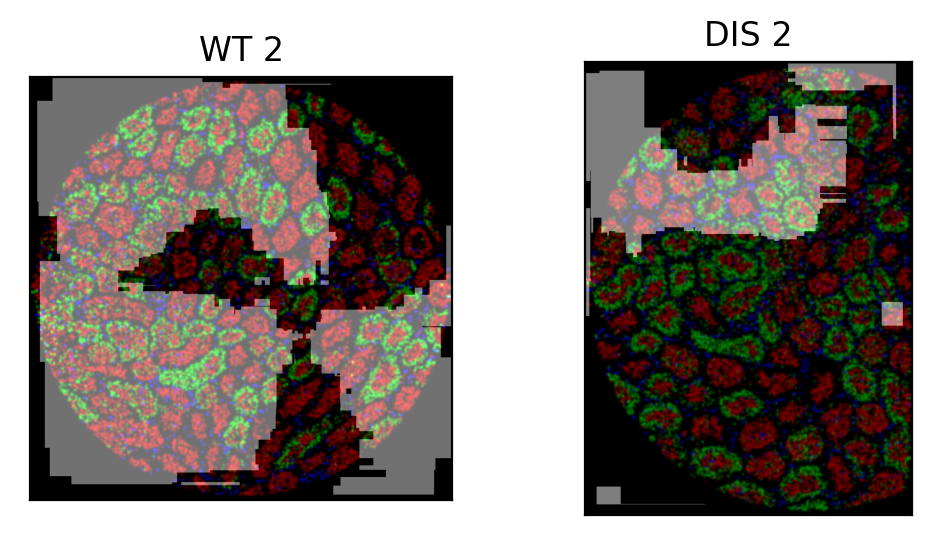

In [84]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(6,3))

ax2.imshow(img_wt2[:, :, :3])
ax2.imshow(mask_2, alpha=0.5, cmap="gray")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("WT 2");

ax1.imshow(img_dis2[:,:,:3])
ax1.imshow(mask_1, alpha=0.45, cmap="gray")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title("DIS 2")



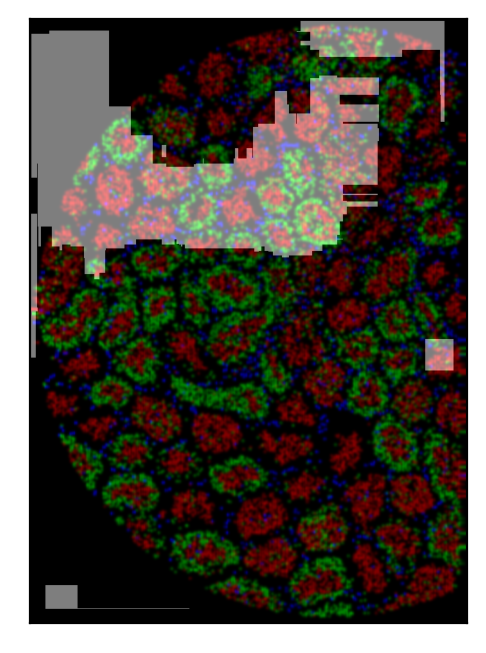

In [83]:
plt.imshow(img_wt2[:, :, :3])
plt.imshow(mask_2, alpha=0.5, cmap="gray")
plt.xticks([])
plt.yticks([]);

In [ ]:
mask_2[mask_2 > 0.9]